<a href="https://colab.research.google.com/github/DBcreator/Coin-problem/blob/master/Coin_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт необходимых библиотек




In [ ]:
! apt-get install -qq protobuf-compiler python-pil python-lxml python-tk 
! pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

In [ ]:
cd /content/drive/My\ Drive/object_detection/models/research/object_detection

/content/drive/My Drive/object_detection/models/research/object_detection


In [ ]:
%tensorflow_version 1.x
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET
from pathlib import Path
import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files
from google.colab.patches import cv2_imshow
from utils import label_map_util
from utils import visualization_utils as vis_util

In [ ]:
print(tf.__version__)


1.15.2


## Разделение аннотаций на train и test

In [ ]:
cd /content/drive/My\ Drive/object_detection/data/

/content/drive/My Drive/object_detection/data


In [ ]:
#creating two dir for training and testing
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 79/320 labels (20% of the labels) to the testing dir: `test_labels`
!ls annotations/* | sort -R | head -79 | xargs -I{} mv {} test_labels/


# Moves the rest of labels '320' labels to the training dir: `train_labels`
!ls annotations/* | xargs -I{} mv {} train_labels/

mkdir: cannot create directory ‘test_labels’: File exists
mkdir: cannot create directory ‘train_labels’: File exists
ls: cannot access 'annotations/*': No such file or directory
ls: cannot access 'annotations/*': No such file or directory


## Создание csv-файла

In [ ]:
cd /content/drive/My\ Drive/object_detection/data/

/content/drive/My Drive/object_detection/data


In [ ]:
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


## Загрузка модуля models из библиотеки tensorflow

In [ ]:
cd /content/drive/My\ Drive/object_detection/

/content/drive/My Drive/object_detection


In [ ]:
! git clone --q https://github.com/tensorflow/models.git

In [ ]:
cd /content/drive/My\ Drive/object_detection/models/research/

/content/drive/My Drive/object_detection/models/research


In [ ]:

!protoc object_detection/protos/*.proto --python_out=.

os.environ['PYTHONPATH'] += ':./:./slim/'

In [ ]:
%cd /content/drive/My\ Drive/object_detection/models/research
!protoc object_detection/protos/*.proto --python_out=.

os.environ['PYTHONPATH'] += ':/content/gun_detection/models/research/:/content/gun_detection/models/research/slim/'

/content/drive/My Drive/object_detection/models/research


In [ ]:
!python3 object_detection/builders/model_builder_test.py

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_experimental_model
[       OK ] ModelBuilderTest.test_create_experimental_model
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_wi

## Создание файлов .tfrecord

In [ ]:
cd /content/drive/My\ Drive/object_detection/models/research

/content/drive/My Drive/object_detection/models/research


In [ ]:
from object_detection.utils import dataset_util

DATA_BASE_PATH = '/content/drive/My Drive/object_detection/data/'
image_dir = DATA_BASE_PATH +'images/'

def class_text_to_int(row_label):
	if row_label == '10rub':
		return 1
	if row_label == '5rub':
		return 2
	if row_label == '10rub_reverse':
		return 3
	if row_label == '5rub_reverse':
		return 4
	else:
		None


def split(df, group):
		data = namedtuple('data', ['filename', 'object'])
		gb = df.groupby(group)
		return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
		with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
				encoded_jpg = fid.read()
		encoded_jpg_io = io.BytesIO(encoded_jpg)
		image = Image.open(encoded_jpg_io)
		width, height = image.size

		filename = group.filename.encode('utf8')
		image_format = b'jpg'
		xmins = []
		xmaxs = []
		ymins = []
		ymaxs = []
		classes_text = []
		classes = []

		for index, row in group.object.iterrows():
				xmins.append(row['xmin'] / width)
				xmaxs.append(row['xmax'] / width)
				ymins.append(row['ymin'] / height)
				ymaxs.append(row['ymax'] / height)
				classes_text.append(row['class'].encode('utf8'))
				classes.append(class_text_to_int(row['class']))

		tf_example = tf.train.Example(features=tf.train.Features(feature={
				'image/height': dataset_util.int64_feature(height),
				'image/width': dataset_util.int64_feature(width),
				'image/filename': dataset_util.bytes_feature(filename),
				'image/source_id': dataset_util.bytes_feature(filename),
				'image/encoded': dataset_util.bytes_feature(encoded_jpg),
				'image/format': dataset_util.bytes_feature(image_format),
				'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
				'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
				'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
				'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
				'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
				'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
		return tf_example

for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(DATA_BASE_PATH + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(DATA_BASE_PATH + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), DATA_BASE_PATH + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(DATA_BASE_PATH +csv + '.record'))


Successfully created the TFRecords: /content/drive/My Drive/object_detection/data/train_labels.record
Successfully created the TFRecords: /content/drive/My Drive/object_detection/data/test_labels.record


## Выбираем модель и изменяем ее конфигурацию


In [ ]:
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    }
}

selected_model = 'ssd_mobilenet_v2'

In [ ]:
#папка для сохранения модели
DEST_DIR = '/content/drive/My Drive/object_detection/models/research/pretrained_model'


# название модели для использования
MODEL = MODELS_CONFIG[selected_model]['model_name']

MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#если модель не загружена, то загружаем
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [ ]:

!cat object_detection/samples/configs/ssd_mobilenet_v2_coco.config

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 90
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

In [ ]:
#изменяем конфигурацию
%%writefile object_detection/samples/configs/ssd_mobilenet_v2_coco.config

# paste the content of the config file in the same cell here.
# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 4
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: true
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              #weight: 0.00004
              weight: 0.001
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            #weight: 0.00004
            weight: 0.001
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100 
        max_total_detections: 100 
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/content/drive/My Drive/object_detection/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 30000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}


train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/object_detection/data/train_labels.record"

  }
  label_map_path: "/content/drive/My Drive/object_detection/data/label_map.pbtxt"
}

eval_config: {
  num_examples: 79
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  #max_evals: 10
  num_visualizations : 5  
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/object_detection/data/test_labels.record"
  }
  label_map_path: "/content/drive/My Drive/object_detection/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting object_detection/samples/configs/ssd_mobilenet_v2_coco.config


## Установка Tensorboard

In [ ]:
cd /content/drive/My Drive/object_detection/

/content/drive/My Drive/object_detection


In [ ]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -o ngrok-stable-linux-amd64.zip

--2020-04-23 18:08:31--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.200.114.213, 34.237.57.234, 3.227.142.238, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.200.114.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  35.9MB/s    in 0.4s    

2020-04-23 18:08:31 (35.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = "training/"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://cb3cc3ff.ngrok.io


## Обучение выбранной модели


In [ ]:
!python3 /content/drive/My\ Drive/object_detection/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/drive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir=training/

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0423 19:58:18.935807 140476187432832 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0423 19:58:18.940432 140476187432832 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0423 19:58:18.940608 140476187432832 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W0423 19:58:18.940740 1

## Экспорт графа 


In [ ]:
#директория, в которой будет сохранена модель
output_directory = './fine_tuned_model'

lst = os.listdir('training')
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join('training', last_model)

In [ ]:
cd /content/drive/My\ Drive/object_detection/models/research/

/content/drive/My Drive/object_detection/models/research


In [ ]:
!python /content/drive/My\ Drive/object_detection/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/drive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0424 12:01:44.094592 140247938951040 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0424 12:01:45.393072 140247938951040 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0424 12:01:45.393634 140247938951040 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/ex

In [ ]:
cd /content/drive/My Drive/object_detection/models/research/

/content/drive/My Drive/object_detection/models/research


In [ ]:
#загрузка графа
files.download(output_directory + '/frozen_inference_graph.pb')

KeyboardInterrupt: ignored

## Тестируем нашу модель

In [ ]:


final_image_directory = "/content/drive/My Drive/object_detection/L"
Frosen_Graph = "./fine_tuned_model/frozen_inference_graph.pb"
label_map_directory = "/content/drive/My Drive/object_detection/data/label_map.pbtxt"
num_classes = 4

In [ ]:

def test(path):
    # load a (frozen) TensorFlow model into memory
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(Frosen_Graph, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    # Loading label map
    label_map = label_map_util.load_labelmap(label_map_directory)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes,
                                                                use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    imageFilePaths = []
    for imageFileName in os.listdir(path):
        if imageFileName.endswith(".jpg"):
            imageFilePaths.append(path + "/" + imageFileName)


    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            for image_path in imageFilePaths:

                Image = cv2.imread(image_path)
            
                image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
                
                detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
                
                detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
                detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
                num_detections = detection_graph.get_tensor_by_name('num_detections:0')

                Image_expanded = np.expand_dims(Image, axis=0)

                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: Image_expanded})
                
                new_image = vis_util.visualize_boxes_and_labels_on_image_array(Image,
                                                                   np.squeeze(boxes),
                                                                   np.squeeze(classes).astype(np.int32),
                                                                   np.squeeze(scores),
                                                                   category_index,
                                                                   use_normalized_coordinates=True,
                                                                   line_thickness=8)
                
                labels = [category_index.get(value) for index, value in enumerate(classes[0]) if scores[0, index] > 0.6] #можно варьировать порог
                Count_10 = 0
                Count_5 = 0
                Count_10_rev = 0
                Count_5_rev = 0

                for i in range(0, int(len(labels))):
                    if str(lables[i]['name']) == "10rub":
                        Count_10 += 1
                    if str(labels[i]['name']) == "5rub":
                        Count_5 += 1
                    if str(labels[i]['name']) == "10rub_reverse":
                      Count_10_rev += 1
                    if str(labels[i]['name']) == "5rub_reverse":
                        Count_5_rev += 1

                cv2_imshow(new_image)
                
                Sum = str(10* Count_10+ 5*Count_5 + 10*Count_10_rev + 5*Count_5_rev) + " Rubles."
                print(Sum)


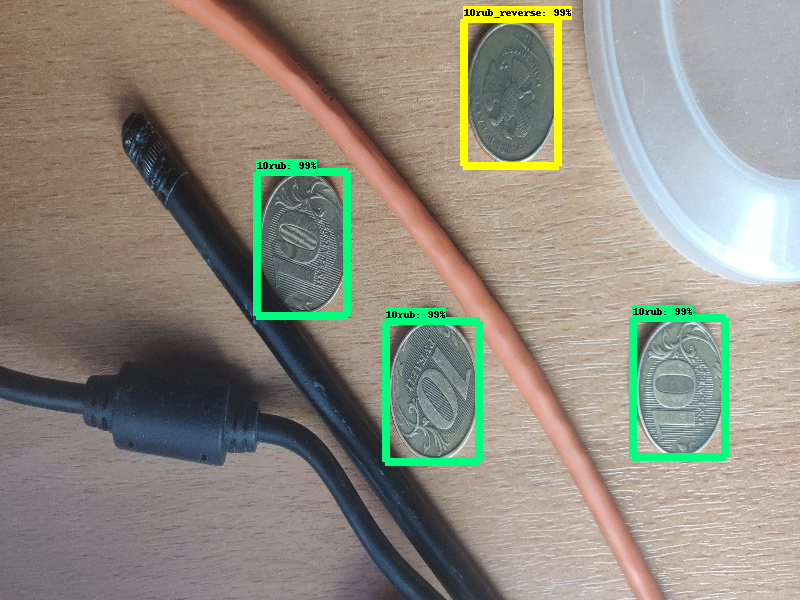

40 Rubles.


In [ ]:
test(final_image_directory)